In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
# A lot of the initialization does not matter so much anymore because of modern innovations
# One of such innovations is batch normalisation
# Came out in 2015 from Google
# Made it possibly to train deep neural networks quiet reliably
# It made the training process JUST WORK

In [4]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [5]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [7]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [8]:
# In the training loop below we have the hidden state h pre activations
# we don't want hpreact to be way to small -> then the tanh doesn't do anything
#                    or to be way to big   -> then the tanh is saturated and no gradients flow back
# we want them to be rougly gaussian
# the insight from batch norm. paper is
# you have the hidden states that you want to be gaussian
# so WHY NOT TAKE THE HIDDEN STATES and NORMALISE THEM TO BE GAUSSIAN
# YOU CAN JUST DO THAT because normalising the hidden states is perfectly differentiable operation
# So let's just do that
# In the following training loop we are trying to roughly make hpreact gaussian
# Since we want to normalise in the batch
# we are going to calculate the mean and std. dev across the batch and then use that to normalize the batch
# while calculating the mean we also want to keep the dimension so we can broadcast it
# the normalisation ensures that every single neuron and it's firing rate will be unit gaussian across this batch
# hence call batch normalisation, since we are normalising the pre non linearities across the whole batch

In [9]:
# Now the problem with this is that
# we want these to be roughly gaussian but only at init
# we don't want them to forced to be gaussian always
# we want the neural network to let the distribution move around a bit depending on how it needs to be optimised
# we want the backprop to optimize how to move it around

# so in addition to the idea of this normalisation, we also need the idea of scale and shift as mentioned in the paper
# we take the normalised input, additionally scale them by some gain and and offset by some bias to get final output from the layers
# this means we need to add these learnable parameters to the network

In [10]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

bngain = torch.ones((1, n_hidden))  # we want the initial values to affect the hpreact in a nice gaussian
bnbias = torch.zeros((1, n_hidden)) # we want the initial values to affect the hpreact in a nice gaussian

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

12297

In [11]:
max_steps = 200000
batch_size = 32

In [12]:
lossi = []
losslog10i = []
stepsi = []

In [13]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    hpreact_mean = hpreact.mean(dim=0, keepdim=True)  # hpreact mean
    hpreact_std  = hpreact.std(dim=0, keepdim=True)   # hpreact std dev
    hpreact = bngain * (hpreact - hpreact_mean)/hpreact_std + bnbias     # normalize hpreact, also scale and shift
    
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3146889209747314
Loss 20000/200000: 2.3374552726745605
Loss 40000/200000: 2.011928081512451
Loss 60000/200000: 2.4775009155273438
Loss 80000/200000: 2.278811454772949
Loss 100000/200000: 1.9473825693130493
Loss 120000/200000: 1.9836552143096924
Loss 140000/200000: 2.3839313983917236
Loss 160000/200000: 1.9733015298843384
Loss 180000/200000: 1.9972705841064453


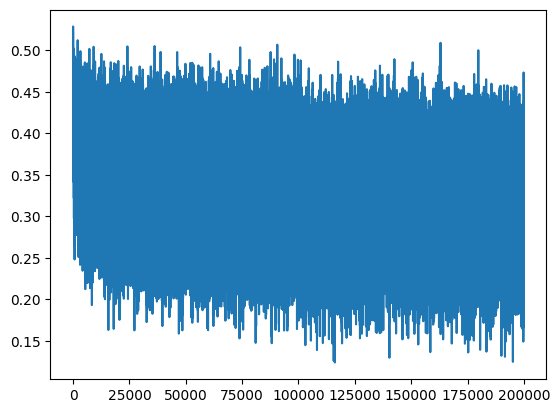

In [14]:
plt.plot(stepsi, losslog10i)

In [15]:
# Need to do the same thing for test time

In [16]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    hpreact_std  = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact_mean)/hpreact_std + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.0668270587921143
val loss : 2.104844808578491


In [17]:
# Batch norm is not doing much here, since we have already initialised properly and the network is shallow
# but with deeper neural nets, different types of connections, for eg. residual connections
# it'll be very difficult to tune the scales of weight matrices so all activations throughout the NN is roughly gaussian
# but it'll be very easy to sprinkle batch norm throughout the NN
# in particular it's common to look at every single linear layer (or convolutions, linear arithmetic)
# and append a batch norm layer right after it to control the scale of these activations that flows out of it the linear/conv. layer
# we do this throughout the neural net, and this controls the activations throughout the neural net
# we don't have to hand tune the mathematics and significantly stabilizes the training

# The stability offered by batch norm COMES AT A TERRIBLE COST
# Something terribly strange and unnatural is happening
# Used to be that we used one example at a time
# Because of efficiency of training we started to use batches of examples, but they were processed in parallel
# But now with batch norm, because of norm. in a batch we introduce a coupling across these examples
# mathematically in the forward and backward pass
# So now, the hpreact and logits are not just a function of one example
# but a function of all the other examples that happen to come for a ride in that batch, and they're sample randomly
# Depending on what other samples come for a ride, h is going to change suddenly and jitter, if one can imagine sampling diff. examples
# because the statistics of mean and std. dev are going to be affected
# Jitter for h, jitter for logits
# One would assume that this is bug, or undesired, but turns out this actually helps out with the NN training as a side effect
# You could think of it as a regularizer based on other examples, sort of like padding with data augmentation

# With this second order effect of regularizer, it has becomes harder to remove batch norm. 
# No one like the property that examples in the property are coupled mathematically and in the forward pass
# People have tried to deprecate use of batch norm and move to other norm techniques that do not couple examples with batch
# Examples are layer normalisation, instance normalisation, group normalisation and so on

# But, batch norm was the first kind of normalisation to be introduced
# works extremely well, happened to have this regularization effect, stablized the training
# people have tried to move to other techniques, but it's been hard because it just works quiet well
# quite effective at controlling activations, their distributions and the reg. effect

# Another strange outcomes
# Once we've trained a NN we'd like to be able to deploy it somewhere
# feed it a single example and get a prediction out from our neural net
# but how do we do that when the NN expects batches ??
# proposal in the paper
# have a step after training that calculates and sets the batch norm mean and std dev a single time over the training set

In [18]:
# calibrate batch norm mean and std dev at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # calculate the bnmean bnstd
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [19]:
# now lets use it at test time

In [20]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    #hpreact_std  = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.0668270587921143
val loss : 2.1049270629882812


In [21]:
# Which means that now we can forward a single example
# because the batch norm mean and std dev are fixed

In [22]:
# Having said that nobody wants to estimate these after the NN training is complete
# One more idea introduced by the batch norm paper
# we can estimate the mean and std dev in a running manner during training of NN
# we estimate on the side while training
# let's see what that looks like

In [23]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

bngain = torch.ones((1, n_hidden))  # we want the initial values to affect the hpreact in a nice gaussian
bnbias = torch.zeros((1, n_hidden)) # we want the initial values to affect the hpreact in a nice gaussian

bnmean_running = torch.zeros((1, n_hidden)) # the way we init W1 and b1, hpreact will be roughly unit gaussian, mean roughly zero
bnstd_running = torch.ones((1, n_hidden))   # std dev roughly one

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

12297

In [24]:
max_steps = 200000
batch_size = 32

In [25]:
lossi = []
losslog10i = []
stepsi = []

In [26]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1          # hidden layer pre-activation
    bnmeani = hpreact.mean(dim=0, keepdim=True)  # bn mean for ith iter        <-----
    bnstdi  = hpreact.std(dim=0, keepdim=True)   # bn std  for ith iter        <----- 
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias     # normalize hpreact, also scale and shift
    
    # not a part of gradient optimisation, keeping track of running values
    with torch.no_grad():
        # mostly what it used to be, a little of where it is headed right now
        
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3146889209747314
Loss 20000/200000: 2.3374552726745605
Loss 40000/200000: 2.011928081512451
Loss 60000/200000: 2.4775009155273438
Loss 80000/200000: 2.278811454772949
Loss 100000/200000: 1.9473825693130493
Loss 120000/200000: 1.9836552143096924
Loss 140000/200000: 2.3839313983917236
Loss 160000/200000: 1.9733015298843384
Loss 180000/200000: 1.9972705841064453


In [27]:
# Lets use it at test time

In [28]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.06659197807312
val loss : 2.1050572395324707


In [29]:
# Batch norm discussion more or less done, two more things
# epsilon in the batch norm normalize equation is a tiny number that prevent division by zero, in case the variance is exactly zero
# second thing we are being a bit wasteful
#    hpreact = embcat @ W1 + b1          <------ CHECK THIS BIAS ADDED HERE
#    bnmeani = hpreact.mean(dim=0, keepdim=True)
#    bnstdi  = hpreact.std(dim=0, keepdim=True)
#    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias     <--- BUT SUBTRACTED HERE
# those biases are not doing anything
# if you look at b1.grad it's going to be zero

# Whenver you're using batch normalisation layer
# if you have weight layers before (linear or conv)
# better off not using bias at all for those layers
# its the bnbias that's in charge of the bias instead of the b1
# batch norm has it own bias, so there's no need to add bias to the weight layers before a bn layer

In [30]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 200 # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3/(block_size*n_embed)**0.5)
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

bngain = torch.ones((1, n_hidden))  # we want the initial values to affect the hpreact in a nice gaussian
bnbias = torch.zeros((1, n_hidden)) # we want the initial values to affect the hpreact in a nice gaussian

bnmean_running = torch.zeros((1, n_hidden)) # the way we init W1 and b1, hpreact will be roughly unit gaussian, mean roughly zero
bnstd_running = torch.ones((1, n_hidden))   # std dev roughly one

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of parameters

12097

In [31]:
max_steps = 200000
batch_size = 32

In [32]:
lossi = []
losslog10i = []
stepsi = []

In [33]:
tot_steps = len(stepsi)

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                         # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1          # hidden layer pre-activation
    bnmeani = hpreact.mean(dim=0, keepdim=True)  # bn mean for ith iter        <-----
    bnstdi  = hpreact.std(dim=0, keepdim=True)   # bn std  for ith iter        <----- 
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias     # normalize hpreact, also scale and shift
    
    # not a part of gradient optimisation, keeping track of running values
    with torch.no_grad():
        # mostly what it used to be, a little of where it is headed right now
        
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)             # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")

Loss 0/200000: 3.3238625526428223
Loss 20000/200000: 2.567518711090088
Loss 40000/200000: 2.2446329593658447
Loss 60000/200000: 2.0785391330718994
Loss 80000/200000: 2.291823148727417
Loss 100000/200000: 2.367293357849121
Loss 120000/200000: 1.6413521766662598
Loss 140000/200000: 2.2231295108795166
Loss 160000/200000: 2.0996553897857666
Loss 180000/200000: 2.0198497772216797


In [34]:
# Finally ets use it at test time without the bias b1

In [35]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 2.0674147605895996
val loss : 2.1056840419769287


In [36]:
# Let's just sample for fun

In [37]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
amorie.
khi.
mri.
reity.
salaysie.
mahnen.
delynn.
jareei.
ner.


In [38]:
# Note our losses going down with tricks

# Train test validation split - in the beginning
# Train Loss : 2.2589
# Val Loss   : 2.2702

# After increasing NN capacity and embedding size
# Train Loss : 2.1190
# Val Loss   : 2.1711

# After fixing init weight bias softmax confidently wrong
# Train loss : 2.0695
# Val loss   : 2.1310

# After fixing tanh saturation
# train loss : 2.0355
# val loss   : 2.1026

# Now, with kaiming init and not using magic numbers for tanh saturation
# train loss : 2.0376
# val loss   : 2.1069

# With batch norm
# train loss : 2.0668
# val loss   : 2.1048